In [1]:
import random_walker as rw
import utils
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

In [2]:
H,root,G=rw.make_tree(2.,20,.1,0.1)

In [3]:
a,b=utils.block_indices(G,G.target_node)

In [4]:
nodes=list(G.nodes())
alpha=[nodes.index(x) for x in a]
beta=[nodes.index(x) for x in b]
root_ind,target_ind=a.index(G.root),a.index(G.target_node)
alpha_leaves=[a.index(leaf)for leaf in utils.leaves(H) if leaf in a]

/home/k1801311/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/k1801311/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/k1801311/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/home/k1801311/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.it

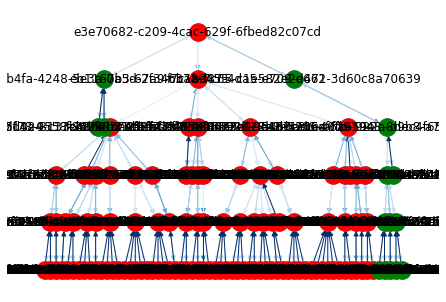

In [5]:
pos=graphviz_layout(H,prog='dot')
(edges,weights) = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, pos, edgelist=edges, edge_color=weights, width=1.0, edge_cmap=plt.cm.Blues)
nx.draw_networkx_nodes(G,pos,nodelist=a,node_color='r')
nx.draw_networkx_nodes(G,pos,nodelist=b,node_color='g')
nx.draw_networkx_labels(G,pos)
plt.show()

In [6]:
G.reset_patterns()
W=nx.to_numpy_matrix(G,nodelist=a+b,weight='weight')
W_alpha=W[:len(a),:len(a)]
W_beta=W[-len(b):,-len(b):]
W_ab=W[:len(alpha),-len(b):]
W_ba=W[-len(b):,:len(a)]
u=np.eye(len(G)-1)-W[1:,1:]
Delta = -W[0,1:]
print(len(G),W_alpha.shape,W_beta.shape,W_ab.shape,W_ba.shape)

125 (110, 110) (15, 15) (110, 15) (15, 110)


In [7]:
pi=np.concatenate(([[1]],-np.matmul(Delta,np.linalg.inv(u)).T))

In [8]:
pi=pi/np.sum(pi)
print(pi.shape)

(125, 1)


In [9]:
np.linalg.norm(np.matmul(pi.T, np.eye(len(G))-W ))

2.824300214266882e-17

In [10]:
X=np.linalg.inv(np.eye(len(a)-1)-W_alpha[1:,1:])
Y=np.linalg.inv( np.eye(len(b))-W_beta )
h=-np.sum(W_alpha[0,:])*X[0,:]
H=np.matmul(np.ones((len(a)-1,1)),h)
delta=np.sum(W_alpha[0,:])*np.sum(np.linalg.matrix_power(X,2)[0,:])
beta=1+np.sum(W_alpha[0,:])*np.sum(X[0,:])
F=X-delta/beta*np.eye(len(a)-1)
y=np.sum(np.matmul(W_ab,Y))

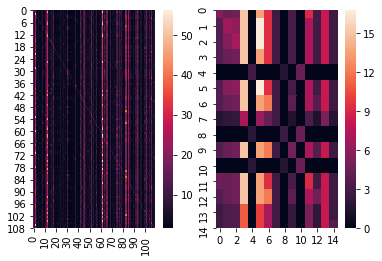

In [25]:
fig,ax=plt.subplots(1,2)
sns.heatmap(X,ax=ax[0])
sns.heatmap(Y,ax=ax[1])
plt.show()

In [11]:
Q=np.zeros((len(a),len(a))) #Q is the gerneralised group inverse of 1-P_alpha #This is not correct yet.
Q[0,0]=delta/beta**2
Q[0,1:] = -W_alpha[0,1]*1/beta*np.array([ np.linalg.matrix_power(X,2)[0,j]-delta/beta*X[0,j] for j in range(len(X))])#1/beta*np.matmul(h,F)
Q[1:,0] = -1/beta*np.squeeze(np.sum(F, axis=1))
Q[1:,1:]=X+1/delta*(np.matmul(np.matmul(X,H),X) - np.matmul(np.matmul(F,H),F))

In [12]:
P_alpha=W_alpha + np.matmul(np.matmul(W_ab,Y),W_ba)

In [13]:
Qdg = np.diag(np.diag(Q))
gamma_alpha=1/np.sum(pi[:len(a)])
pi_alpha=pi[:len(a)]*gamma_alpha
pi_alpha=np.squeeze(np.array([x for x in pi_alpha]))
MQ = np.matmul(np.eye(len(a))-Q+np.matmul(np.ones((len(a),len(a))),Qdg),np.diag(1/pi_alpha))

In [14]:
V_alpha=np.zeros((len(a),len(a)))
FJ=np.matmul(F,np.ones((len(a)-1,len(a)-1)))
V_alpha[0,1:]=delta/beta**2+1/beta*FJ[:,0].T
V_alpha[1:,0]=-delta/beta**2-1/beta*np.squeeze(FJ[:,0])
V_alpha[1:,1:]=-1/beta*(FJ-FJ.T)
V_alpha=y*V_alpha

In [15]:
M=gamma_alpha*MQ+V_alpha
print(M[root_ind,target_ind],np.max(M))

1158.1408212445742 1485.2732539246826


(array([4., 2., 2., 1., 3., 2., 1., 3., 6., 4., 7., 2., 3., 6., 6., 7., 1.,
        1., 0., 2.]),
 array([ 470.71208765,  516.85979088,  563.00749412,  609.15519735,
         655.30290058,  701.45060381,  747.59830704,  793.74601027,
         839.89371351,  886.04141674,  932.18911997,  978.3368232 ,
        1024.48452643, 1070.63222966, 1116.7799329 , 1162.92763613,
        1209.07533936, 1255.22304259, 1301.37074582, 1347.51844905,
        1393.66615229]),
 <a list of 20 Patch objects>)

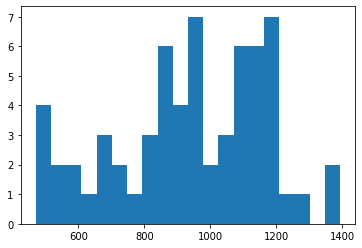

In [16]:
plt.hist([M[0,leaf] for leaf in alpha_leaves],bins=20)
#plt.show()

/home/k1801311/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/k1801311/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


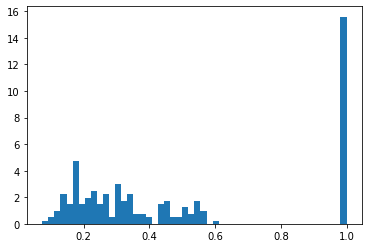

In [17]:
plt.hist(np.where(W_alpha>0,W_alpha,np.nan).flat,bins=50,density=True)
plt.show()

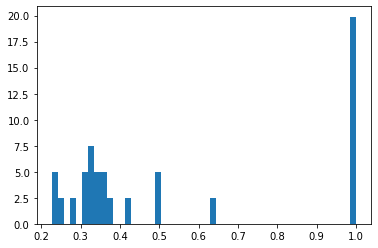

In [18]:
plt.hist(np.where(W_beta>0,W_beta,np.nan).flat,bins=50,density=True)
plt.show()

In [19]:
print(np.mean(W_alpha),np.std(W_alpha))
print(np.mean(W_beta),np.std(W_beta))

0.009044725328147788 0.08063333014619395
0.06409340866290018 0.20597117823327382
